In [2]:
import json
import pandas as pd

headers = []
data = []

def parse_line(line):
  return list(map(lambda x: x.strip(), line.split('|')))

with open('../outputs/dish_status.20240522_113723.log', 'r') as f:
  for index, line in enumerate(f):
    row = parse_line(line)
    if index == 0:
      headers.extend(row)
    else:
      data.append(row)

df = pd.DataFrame(data, columns=headers)




In [5]:
json_data = json.loads(data[0][1])
print(json_data)


{'id': '0', 'status': None, 'apiVersion': '17', 'dishGetStatus': {'deviceInfo': {'id': 'ut01000000-00000000-0085fd5f', 'hardwareVersion': 'rev4_prod1', 'softwareVersion': 'd8c0f816-b72e-4a22-94d5-bb69144fd759.uterm_manifest.release', 'countryCode': 'US', 'utcOffsetS': -14399, 'softwarePartitionsEqual': False, 'isDev': False, 'bootcount': 34, 'antiRollbackVersion': 0, 'isHitl': False, 'manufacturedVersion': '', 'generationNumber': '1715651906', 'dishCohoused': False, 'boardRev': 0, 'boot': None}, 'deviceState': {'uptimeS': '2337'}, 'secondsToFirstNonemptySlot': 0, 'popPingDropRate': 0, 'obstructionStats': {'fractionObstructed': 0.19086957, 'validS': 1229, 'currentlyObstructed': False, 'avgProlongedObstructionDurationS': 6.616022, 'avgProlongedObstructionIntervalS': 2160, 'avgProlongedObstructionValid': False, 'timeObstructed': 0.024145393, 'patchesValid': 2300}, 'alerts': {'motorsStuck': False, 'thermalShutdown': False, 'thermalThrottle': False, 'unexpectedLocation': False, 'mastNotNear

In [3]:
# time difference between each calls

df['datetime'] = pd.to_datetime(df['utc_time_micro'].apply(int), unit='us')
df['time_diff_ms'] = df['datetime'].diff().dt.total_seconds() * 1000
df['datetime'] = df['datetime'].dt.tz_localize('UTC').dt.tz_convert('Etc/GMT+4')


print(df[['datetime', 'time_diff_ms']])

                           datetime  time_diff_ms
0  2024-05-22 11:37:23.792418-04:00           NaN
1  2024-05-22 11:37:24.201339-04:00       408.921
2  2024-05-22 11:37:24.476595-04:00       275.256
3  2024-05-22 11:37:24.767338-04:00       290.743
4  2024-05-22 11:37:25.180737-04:00       413.399
5  2024-05-22 11:37:25.477381-04:00       296.644
6  2024-05-22 11:37:25.792886-04:00       315.505
7  2024-05-22 11:37:26.201192-04:00       408.306
8  2024-05-22 11:37:26.495836-04:00       294.644
9  2024-05-22 11:37:26.816793-04:00       320.957
10 2024-05-22 11:37:27.257445-04:00       440.652
11 2024-05-22 11:37:27.697872-04:00       440.427
12 2024-05-22 11:37:28.120597-04:00       422.725
13 2024-05-22 11:37:28.567745-04:00       447.148
14 2024-05-22 11:37:28.872855-04:00       305.110
15 2024-05-22 11:37:29.218678-04:00       345.823
16 2024-05-22 11:37:29.698975-04:00       480.297
17 2024-05-22 11:37:30.120824-04:00       421.849
18 2024-05-22 11:37:30.396942-04:00       276.118


In [53]:
# Analysis time_sync issue between starlink metrics and phone metrics

import os
import pandas as pd
import re
import json

current_dir = os.getcwd()
print(current_dir)


dish_log_folder =os.path.join(current_dir, './time_sync_with_starlink/maine_starlink_trip/dish_metrics/20240526/110712373')
status_log = f'{dish_log_folder}/dish_status.out'

def parse_line(line):
  if line.startswith('Start time'):
    return {
      'start_time': line.split(':')[-1].strip()
    }
  if line.startswith('End time'):
    return {
      'end_time': line.split(':')[-1].strip()
    }

  pattern = r"(\w+):\s([^\|]+)"
    # use reg to extract data from items like "key: value"
  matches = re.findall(pattern, line)

  result = {key: value.strip() for key, value in matches}
  return result

start_time = None
end_time = None
rows = []

with open(status_log, 'r') as f:
  for index, line in enumerate(f):
    row = parse_line(line)
    if 'start_time' in row:
      start_time = row['start_time']
    if 'end_time' in row:
      end_time = row['end_time']
    if 'data' in row:
      row['data'] = json.loads(row['data'])
      rows.append(row)

df = pd.DataFrame(rows)
# print(df)

# plot throughput trace over time

# outage_df = df['req', 'res', df['data'].apply(lambda x: 'outage' in x)]
def derive_outage_fields(data):
  outage = data['dishGetStatus']['outage']
  if not outage:
    return pd.Series([None, None, None, None])
  return pd.Series([
    outage['cause'],
    outage['startTimestampNs'],
    outage['durationNs'],
    outage['didSwitch']
  ])

def derive_obstruction_fields(data):
  obstruction = data['dishGetStatus']['obstructionStats']
  if not obstruction:
    return pd.Series([None])
  return pd.Series([
    obstruction['fractionObstructed'],
  ])

def derive_throughput_fields(data):
  throughput = data['dishGetStatus']
  return pd.Series([
    throughput['downlinkThroughputBps'],
    throughput['uplinkThroughputBps']
  ])


sl_metric_df = df[['req', 'res']]
sl_metric_df[['outage.cause', 'outage.start_t_ns', 'outage.duration_ns', 'outage.did_switch']] = df['data'].apply(derive_outage_fields)
sl_metric_df[['dl_throughput_bps', 'ul_throughput_bps']] = df['data'].apply(derive_throughput_fields)
sl_metric_df['latency_ms'] = df['data'].apply(lambda x: x['dishGetStatus']['popPingLatencyMs'])
sl_metric_df[['obs.fraction']] = df['data'].apply(derive_obstruction_fields)



/Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks


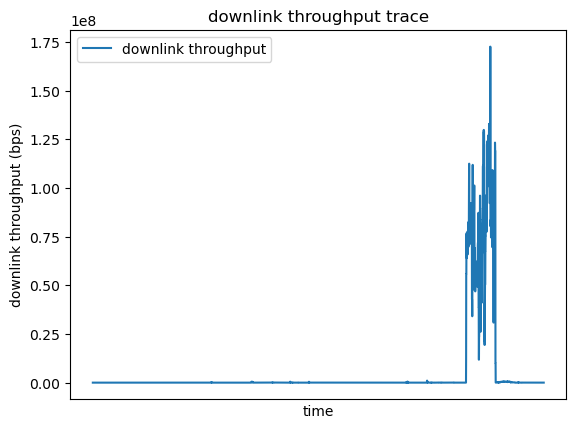

In [54]:

# print(outage_df.head())
# print('enum of outage cause', outage_df['outage.cause'].unique())
  
# # remove invalid data points that have -1 or None start_t_ns
# print('original data count', outage_df.count())

# def filter_valid_start_ts(row):
#   start_t = row['outage.start_t_ns']
#   res =  start_t is not None and start_t != '-1'
#   return res
# valid_outage_df = outage_df[outage_df.apply(filter_valid_start_ts, axis=1)]

# print('valid data count', valid_outage_df.count())


# plot throughput trace
import matplotlib.pyplot as plt
import numpy as np

# downlink throughput only
fig, ax = plt.subplots()
ax.plot(sl_metric_df['res'], sl_metric_df['dl_throughput_bps'], label='downlink throughput')
ax.set_xlabel('time')
ax.set_ylabel('downlink throughput (bps)')
ax.set_title('downlink throughput trace')
ax.legend()
plt.xticks([])
plt.show()



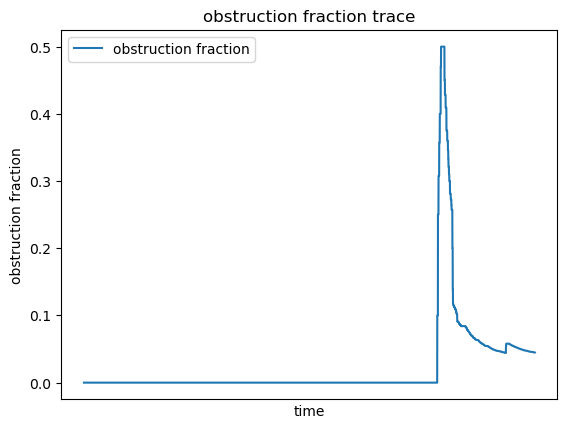

In [55]:
# obstruction fraction
fig, ax = plt.subplots()
ax.plot(sl_metric_df['res'], sl_metric_df['obs.fraction'], label='obstruction fraction')
ax.set_xlabel('time')
ax.set_ylabel('obstruction fraction')
ax.set_title('obstruction fraction trace')
ax.legend()
# don't show x axis label
plt.xticks([])
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a None

Error in callback <function _draw_all_if_interactive at 0x1392c9300> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

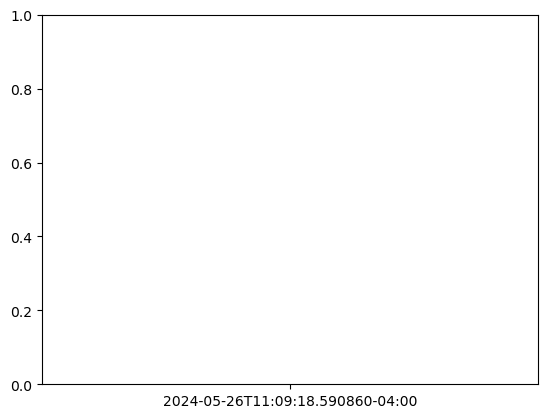